In [1]:
import pymc3 as pm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

from jupyterthemes import jtplot
jtplot.style('oceans16')
%matplotlib inline

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

411             fprintf(stderr,
412                     "CudaNdarray_uninit: error freeing self->devdata. (self=%p, self->devata=%p)\n",
413                     self, self->devdata);
414             rval = -1;
415         }
416         self->devdata = NULL;
417         self->data_allocated = 0;
418     }
419     if (self->dev_structure)
420     {
421         if (device_free(self->dev_structure))
422         {
423             fprintf(stderr,
424                     "CudaNdarray_uninit: error freeing dev_structure memory %p (self=%p)\n",
425                     self->dev_structure, self);
426             rval = -1;
427         }
428         self->dev_structure = NULL;
429     }
430     if (self->host_structure)
431     {
432         free(self->host_structure);
433         self->host_structure = NULL;
434     }
435     self->nd = -1;
436     Py_XDECREF(self->base);
437     self->base = NULL;
438     return rval;
439 }
440 
441 
442 //make the rightmost coords change fastest
443 //TODO: wh

1620                                 break;
1621                             case CPY:
1622                                 a[i0*sA0 + i1*sA1 + i2*sA2 + i3*sA3 + i4*sA4 + i5*sA5]
1623                                     = b[i0*sB0 + i1*sB1 + i2*sB2 + i3*sB3 + i4*sB4 + i5*sB5];
1624                                 break;
1625                             }
1626                         }
1627                     }
1628                 }
1629             }
1630         }
1631     }
1632 }
1633 
1634 /*
1635 CudaNdarray_inplace_elemwise
1636 Compute elemwise, working inplace on A.
1637 Currently implemented A / B, A + B and A = B
1638 (the last is not tested and not used!)
1639 
1640 py_self - the CudaNdarray that we'll modify (A)
1641 py_other - the other argument (B)
1642 fct_nb - which operation to perform (operator_t)
1643 
1644 Returns 0 on success.
1645 Returns -1 on failure, and sets Python exception.
1646 
1647 */
1648 int
1649 CudaNdarray_inplace_elemwise(PyObject* py_self, PyObjec

2793 static PyObject *
2794 CudaNdarray_get_ndim(CudaNdarray *self, void *closure)
2795 {
2796     return PyInt_FromLong(self->nd);
2797 }
2798 
2799 static PyObject *
2800 CudaNdarray_get_base(CudaNdarray *self, void *closure)
2801 {
2802     PyObject * base = self->base;
2803     if (!base)
2804     {
2805         // We cannot return a NULL pointer, use None instead
2806         base = Py_None;
2807     }
2808     Py_INCREF(base);
2809     return base;
2810 }
2811 
2812 void put_in_dict(PyObject * dict, const char * key, int val)
2813 {
2814   PyObject * k = PyString_FromString(key);
2815   PyObject * v = PyInt_FromLong(val);
2816   PyDict_SetItem(dict, k, v);
2817   Py_DECREF(k);
2818   Py_DECREF(v);
2819 }
2820 
2821 PyObject *
2822 GetDeviceProperties(PyObject* _unused, PyObject* args)
2823 {
2824   int dev_id = -1;
2825   if (! PyArg_ParseTuple(args, "i", &dev_id))
2826     return NULL;
2827   cudaDeviceProp deviceProp;
2828   cudaGetDeviceProperties(&deviceProp, dev_id);
2829 
2

4237     }
4238     if (CudaNdarray_HOST_STRIDES(B)[1] == 1 || CudaNdarray_HOST_DIMS(B)[1] <= 1) {
4239         unit |= (0x0 << 4);
4240     } else if (CudaNdarray_HOST_STRIDES(B)[0] == 1 || CudaNdarray_HOST_DIMS(B)[0] <= 1) {
4241         unit |= (0x1 << 4);
4242     } else {
4243         unit |= (0x2 << 4);
4244     }
4245     if (CudaNdarray_HOST_STRIDES(C)[1] == 1 || CudaNdarray_HOST_DIMS(C)[1] <= 1) {
4246         unit |= (0x0 << 0);
4247     } else if (CudaNdarray_HOST_STRIDES(C)[0] == 1 || CudaNdarray_HOST_DIMS(C)[0] <= 1) {
4248         unit |= (0x1 << 0);
4249     } else {
4250         unit |= (0x2 << 0);
4251     }
4252 
4253     /* create appropriate strides for malformed matrices that are row or column
4254      * vectors
4255      */
4256     int sa_0 = (CudaNdarray_HOST_DIMS(A)[0] > 1) ? CudaNdarray_HOST_STRIDES(A)[0] : CudaNdarray_HOST_DIMS(A)[1];
4257     int sa_1 = (CudaNdarray_HOST_DIMS(A)[1] > 1) ? CudaNdarray_HOST_STRIDES(A)[1] : CudaNdarray_HOST_DIMS(A)[0];
4258   

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


nvcc fatal   : Cannot find compiler 'cl.exe' in PATH

['nvcc', '-shared', '-O3', '--use-local-env', '--cl-version=2015', '-Xlinker', '/DEBUG', '-D HAVE_ROUND', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=m18715462c72ed6afcd7ca5d52813ce90,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,/Zi,/MD', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\theano\\sandbox\\cuda"', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\numpy\\core\\include"', '-I"C:\\Users\\ares\\Anaconda3\\include"', '-I"C:\\Users\\ares\\Anaconda3\\lib\\site-packages\\theano\\gof"', '-L"C:\\Users\\ares\\Anaconda3\\libs"', '-L"C:\\Users\\ares\\Anaconda3"', '-o', 'C:\\Users\\ares\\AppData\\Local\\Theano\\compiledir_Windows-10-10.0.16299-SP0-Intel64_Family_6_Model_158_Stepping_9_GenuineIntel-3.6.3-64\\cuda_ndarray\\cuda_ndarray.pyd', 'mod.cu', '-lcublas', '-lpython36', '-lcudart']


C:\Users\ares\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [118]:
x = np.linspace(0, 2, 500)
y = np.array([(np.random.normal(loc=0.3, scale=0.2, size=500)),
(np.random.normal(loc=1.8, scale=0.1, size=500))])
y = np.hstack(y)
# y = np.random.shuffle(np.hstack(y))
y = np.expand_dims(y, axis=0)

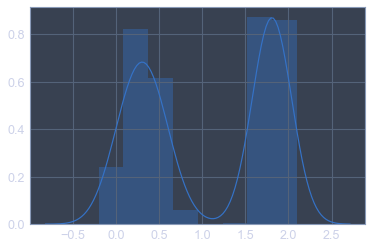

In [119]:
sns.distplot(y)

In [141]:
model = pm.Model()
k = 2
with model:
    p = pm.Dirichlet('p', a=np.array(np.ones(k)), shape=k)
    p_min_potential = pm.Potential('p_pot', tt.switch(tt.min(p) < 0.1, -np.inf, 0))
    
    means = pm.Normal('means', mu=np.zeros(k), sd=4, shape=k)
    order_means_potential = pm.Potential('order_means_potential',
                                        tt.switch(means[1]-means[0] < 0, -np.inf,0))
    
    sd = pm.Uniform('sd', lower=0, upper=20)
    cat = pm.Categorical('category', p=p, shape=len(y.T))
    points = pm.Normal('obs', mu=means[cat], sd=sd, observed=y)

In [143]:
with model:
   trace = pm.sample(4000)

Assigned NUTS to p_stickbreaking__
Assigned NUTS to means
Assigned NUTS to sd_interval__
Assigned BinaryGibbsMetropolis to category
C:\Users\ares\Anaconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████████████████████████████████████████████████████████████████████████| 4500/4500 [17:19<00:00,  4.33it/s]C:\Users\ares\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.8789749094952836, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))



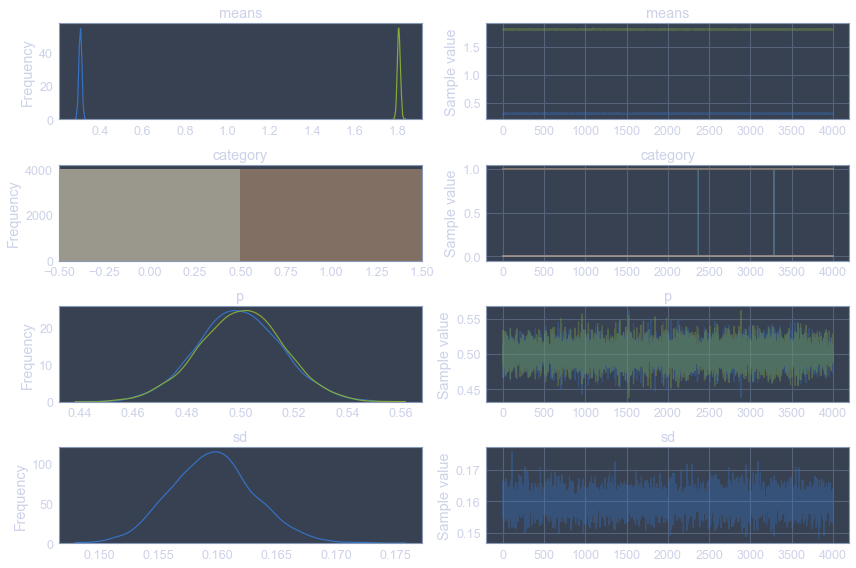

In [144]:
pm.traceplot(trace);

In [91]:
pm.Potential?

In [69]:
np.random.shuffle(y)
for sublist in y:
    np.random.shuffle(sublist)

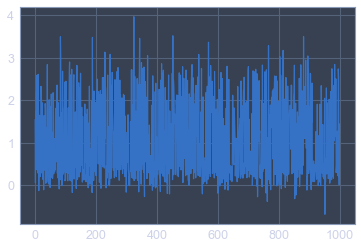

In [70]:
plt.plot(y.T)

In [96]:
len(y.T)

1000